**Houses' prices predicting course project**

In [93]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='svg'

In [94]:
matplotlib.rcParams.update({'font.size':14})

**True vs Predicted comparison function**

In [95]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t"+str(round(r2(true_values, pred_values),3))+"\n"+
          "MAE:\t"+str(round(mae(true_values, pred_values),3))+"\n"+
          "MSE:\t"+str(round(mse(true_values, pred_values),3)))
    
    plt.figure(figsize=(10,10))
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

**Datasets' paths**

In [99]:
train_dataset='/Users/kirillvolkov/Курсовая/train.csv'
df=pd.read_csv(train_dataset)

In [100]:
test_dataset='/Users/kirillvolkov/Курсовая/test.csv'
test_df=pd.read_csv(test_dataset)

In [101]:
df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [102]:
test_df.head(2)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [104]:
df.shape

(10000, 20)

**1. Fill in gaps in the LifeSquare with median values:**

In [105]:
df.loc[df['LifeSquare'].isnull(),'LifeSquare']=df['LifeSquare'].median()

In [106]:
test_df.loc[test_df['LifeSquare'].isnull(),'LifeSquare']=test_df['LifeSquare'].median()

**2. Fill in gaps in the Healthcare_1 with median values:**

In [107]:
df.loc[df['Healthcare_1'].isnull(),'Healthcare_1']=df['Healthcare_1'].median()

In [108]:
test_df.loc[test_df['Healthcare_1'].isnull(),'Healthcare_1']=test_df['Healthcare_1'].median()

**3. Correct unusual values in the LifeSquare & the KitchenSquare by mean values:**

In [109]:
df.loc[(df['LifeSquare']+df['KitchenSquare'])-10>df['Square'],'LifeSquare']=df['LifeSquare'].mean()
df.loc[(df['LifeSquare']+df['KitchenSquare'])-10>df['Square'],'KitchenSquare']=df['KitchenSquare'].mean()

In [110]:
test_df.loc[(test_df['LifeSquare']+test_df['KitchenSquare'])-10>test_df['Square'],'LifeSquare']=test_df['LifeSquare'].mean()
test_df.loc[(test_df['LifeSquare']+test_df['KitchenSquare'])-10>test_df['Square'],'KitchenSquare']=test_df['KitchenSquare'].mean()

**4. Correction of the wrong rooms numbers**

In [111]:
 df.loc[(df['Rooms'] < 1), :]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1397  12638          27    0.0  138.427694  136.215499            0.0      4   
1981   7917          27    0.0  212.932361  211.231125            0.0      2   
2269   7317          27    0.0   41.790881   32.781260            0.0     13   
3911    770          28    0.0   49.483501   32.781260            0.0     16   
4366    456           6    0.0   81.491446   32.781260            0.0      4   
4853   3224          27    0.0    2.377248    0.873147            0.0      1   
6149   3159          88    0.0   38.697117   19.345131            9.0      9   
8834   9443          27    0.0   87.762616   85.125471            0.0      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1397         3.0       2016   0.075424         B         B        11   
1981         3.0       2008   0.211401         B         B         9   
2269         0.0       1977   0.211401         B         B         9   
3911         0.0       2015   0.118537         B         B        30   
4366         0.0       1977   0.243205         B         B         5   
4853         0.0       1977   0.017647         B         B         2   
6149        16.0       1982   0.127376         B         B        43   
8834        15.0       1977   0.211401         B         B         9   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1397      3097         0         900.0            0        0       B   
1981      1892         0         900.0            0        1       B   
2269      1892         0         900.0            0        1       B   
3911      6207         1        1183.0            1        0       B   
4366      1564         0         540.0            0        0       B   
4853       469         0         900.0            0        0       B   
6149      8429         3         900.0            3        9       B   
8834      1892         0         900.0            0        1       B   

              Price  
1397  268394.744389  
1981  302211.260887  
2269   98129.976788  
3911  217009.338463  
4366  212864.799112  
4853  126596.941798  
6149  158998.110646  
8834  219281.918007

In [112]:
def no_rooms(df):
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] < 40), 'Rooms'] = 1
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] >= 40) & (df['LifeSquare'] < 60), 'Rooms'] = 2
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] >= 60) & (df['LifeSquare'] < 90), 'Rooms'] = 3
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] > 90) & (df['LifeSquare'] < 150), 'Rooms'] = 4
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] > 150), 'Rooms'] = 6
    df.loc[(df['Rooms'] >= 10), 'Rooms'] = 2

In [113]:
no_rooms(df)

In [114]:
no_rooms(test_df)

**House year concerns**

In [115]:
df.loc[(df['HouseYear'] > 2020),:]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814         109    1.0  37.265070   20.239714            9.0      9   
4189  11607         147    2.0  44.791836   28.360393            5.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497        12.0   20052011   0.136330         B         B        30   
4189         9.0       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1497      6141        10         262.0            3        6       B   
4189      4756        16        2857.0            5        8       B   

              Price  
1497  254084.534396  
4189  243028.603096

In [116]:
df.loc[(df['HouseYear'] > 2020), 'HouseYear']=df['HouseYear'].mean()

In [117]:
test_df.loc[(test_df['HouseYear'] > 2020), 'HouseYear']=test_df['HouseYear'].mean()

**Rooms vs Square comparison**

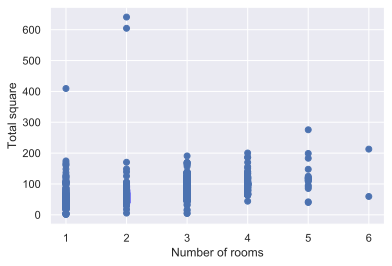

In [118]:
plt.scatter(df.Rooms, df.Square)
plt.xlabel('Number of rooms')
plt.ylabel('Total square')
plt.show()

In [119]:
df.loc[(df['Square'] > 200) & (df['Rooms'] < 3), 'Square']=df.loc[(df['Square'] > 200) & (df['Rooms'] < 3), 'LifeSquare']+df.loc[(df['Square'] > 200) & (df['Rooms'] < 3), 'KitchenSquare']

In [120]:
test_df.loc[(test_df['Square'] > 200) & (test_df['Rooms'] < 3), 'Square']=test_df.loc[(test_df['Square'] > 200) & (test_df['Rooms'] < 3), 'LifeSquare']+test_df.loc[(test_df['Square'] > 200) & (test_df['Rooms'] < 3), 'KitchenSquare']

**Total square too small**

In [121]:
df.loc[(df['Square'] < 15),'Square']=df.loc[(df['Square'] < 15),'LifeSquare']+df.loc[(df['Square'] < 15),'KitchenSquare']

In [122]:
df.loc[(df['Square'] < 15),'Square']=df['Square'].mean()

In [123]:
test_df.loc[(test_df['Square'] < 15),'Square']=test_df.loc[(test_df['Square'] < 15),'LifeSquare']+test_df.loc[(test_df['Square'] < 15),'KitchenSquare']

In [124]:
test_df.loc[(test_df['Square'] < 15),'Square']=test_df['Square'].mean()

In [125]:
df.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.889000     56.282931     35.024371   
std     4859.01902     43.587592      0.813723     19.962008     16.211844   
min        0.00000      0.000000      1.000000     16.117154      0.370619   
25%     4169.50000     20.000000      1.000000     41.790707     25.596603   
50%     8394.50000     36.000000      2.000000     52.541997     32.781260   
75%    12592.50000     75.000000      2.000000     65.890819     40.632225   
max    16798.00000    209.000000      6.000000    648.163193    638.163193   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean        5.722121      8.526700     12.609400   1985.266433      0.118858   
std         4.039049      5.241148      6.775974     33.809479      0.119025   
min         0.000000      1.000000      0.000000   1910.000000      0.000000   
25%         1.000000      4.000000      9.000000   1974.000000      0.017647   
50%         6.000000      7.000000     13.000000   1977.000000      0.075424   
75%         9.000000     12.000000     17.000000   2001.000000      0.195781   
max        58.000000     42.000000    117.000000   3990.166300      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1026.358900      1.319500   
std       17.532614   4006.799803     23.831875    746.662828      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    830.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000    990.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

In [126]:
df_obj_feaures=df.select_dtypes(include='object')
df_obj_feaures.head()

Ecology_2 Ecology_3 Shops_2
0         B         B       B
1         B         B       B
2         B         B       B
3         B         B       B
4         B         B       B

In [127]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [128]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [129]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**Transforming of categorical features to several binary**

for df

In [130]:
df=pd.concat([df, pd.get_dummies(df['Ecology_2']).rename(columns=lambda x: 'Ecology_2_' + str(x))],axis=1)
df=pd.concat([df, pd.get_dummies(df['Ecology_3']).rename(columns=lambda x: 'Ecology_3_' + str(x))],axis=1)
df=pd.concat([df, pd.get_dummies(df['Shops_2']).rename(columns=lambda x: 'Shops_2_' + str(x))],axis=1)

In [131]:
df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ... Helthcare_2 Shops_1  Shops_2  \
0         9.0     1969.0   0.089040  ...           0      11        B   
1         9.0     1978.0   0.000070  ...           1      16        B   
2        12.0     1968.0   0.049637  ...           1       3        B   
3        17.0     1977.0   0.437885  ...           0       5        B   
4        12.0     1976.0   0.012339  ...           2       4        B   

           Price  Ecology_2_A  Ecology_2_B  Ecology_3_A  Ecology_3_B  \
0  184966.930730            0            1            0            1   
1  300009.450063            0            1            0            1   
2  220925.908524            0            1            0            1   
3  175616.227217            0            1            0            1   
4  150226.531644            0            1            0            1   

  Shops_2_A  Shops_2_B  
0         0          1  
1         0          1  
2         0          1  
3         0          1  
4         0          1  

[5 rows x 26 columns]

for test_df

In [132]:
test_df=pd.concat([test_df, pd.get_dummies(test_df['Ecology_2']).rename(columns=lambda x: 'Ecology_2_' + str(x))],axis=1)
test_df=pd.concat([test_df, pd.get_dummies(test_df['Ecology_3']).rename(columns=lambda x: 'Ecology_3_' + str(x))],axis=1)
test_df=pd.concat([test_df, pd.get_dummies(test_df['Shops_2']).rename(columns=lambda x: 'Shops_2_' + str(x))],axis=1)

**Feature names selection**

In [133]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [134]:
feature_names=['DistrictId', 'Square','KitchenSquare','Floor','HouseFloor','HouseYear',
               'Ecology_1','Social_2','Social_3','Healthcare_1','Helthcare_2',
               'Ecology_2_A','Ecology_3_A','Shops_2_A']

In [135]:
target_name='Price'

In [136]:
test_df=test_df[feature_names]

In [137]:
df=df[feature_names+[target_name]]

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
DistrictId       10000 non-null int64
Square           10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null float64
Ecology_1        10000 non-null float64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Ecology_2_A      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Price            10000 non-null float64
dtypes: float64(7), int64(5), uint8(3)
memory usage: 966.9 KB


**Division into test and train datasets**

In [139]:
x=df[feature_names]
y=df[target_name]

In [140]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.33, shuffle=True, random_state=42)

**Построение базовых моделей и выбор лучшей**

Gradient Boosting

In [141]:
gb_model=GradientBoostingRegressor()

In [142]:
gb_model.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [143]:
y_train_preds=gb_model.predict(x_train)

R2:	0.772
MAE:	28931.219
MSE:	1969679593.855


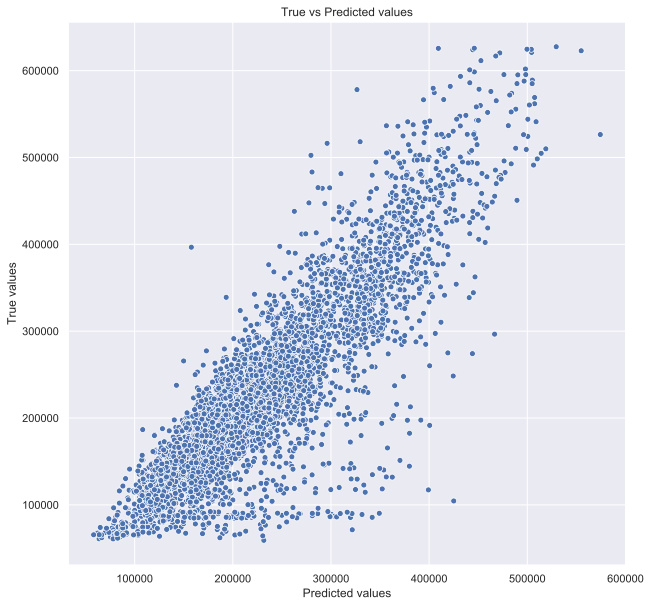

In [144]:
evaluate_preds(y_train,y_train_preds)

In [145]:
y_test_preds=gb_model.predict(x_test)

R2:	0.706
MAE:	30835.441
MSE:	2533444488.616


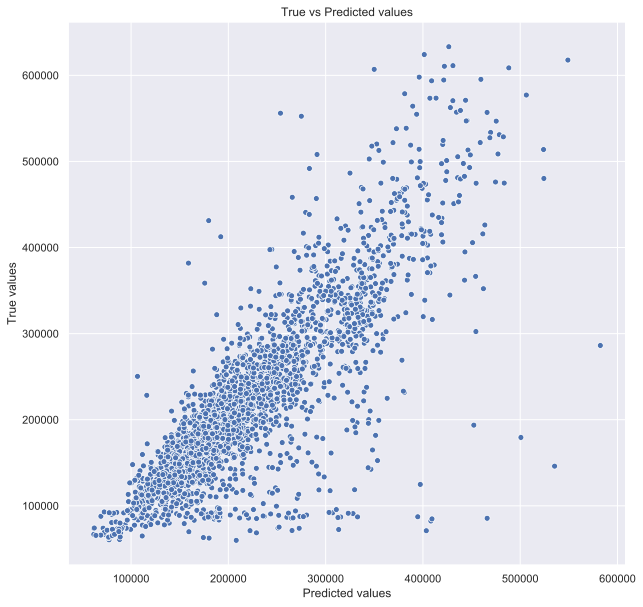

In [146]:
evaluate_preds(y_test,y_test_preds)

**Настройка и оценка модели**

In [147]:
gb_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [148]:
params={'learning_rate':[0.1,0.05,0.025],
        'min_samples_split':[3,4,5],
        'n_estimators':[400,500,600],
        'max_depth':[3,5,7]}

In [149]:
gs=GridSearchCV(gb_model, params, scoring='r2',cv=KFold(n_splits=3,random_state=42, shuffle=True), n_jobs=-1)

In [150]:
gs.fit(x,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_wei...
                                                 n_iter_no_change=None,
                                          

In [151]:
gs.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_samples_split': 4,
 'n_estimators': 500}

In [152]:
gs.best_score_

0.7460369182762199

**Обучение и оценка модели**

In [153]:
final_model=GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=4,
                                      n_estimators=500)

In [154]:
final_model.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [155]:
y_train_preds=final_model.predict(x_train)

R2:	0.909
MAE:	18396.24
MSE:	783422009.652


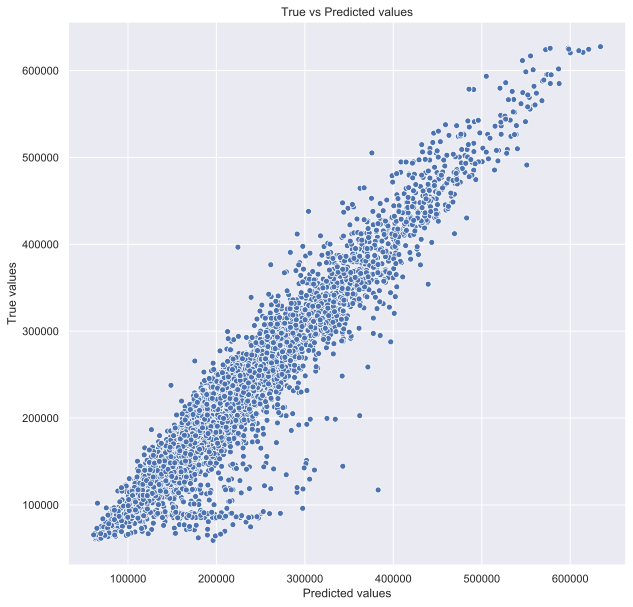

In [156]:
evaluate_preds(y_train,y_train_preds)

In [157]:
y_test_preds=final_model.predict(x_test)

R2:	0.74
MAE:	27360.513
MSE:	2238937048.119


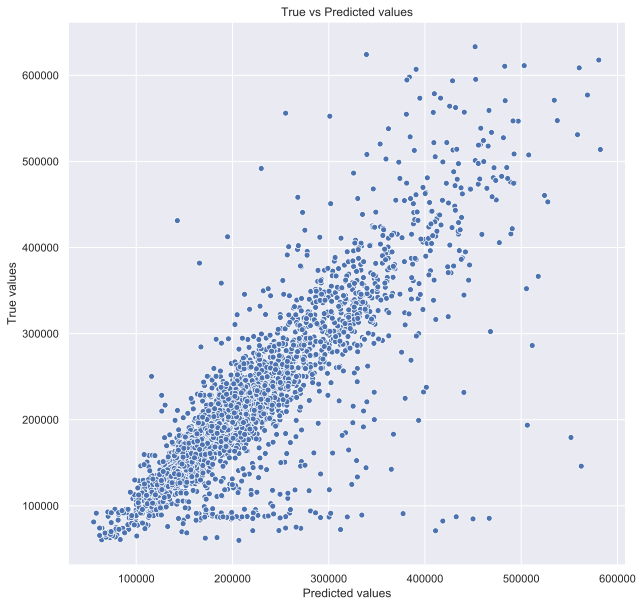

In [158]:
evaluate_preds(y_test,y_test_preds)

**Feature importances checking**

In [159]:
feature_importances=pd.DataFrame(zip(x_train.columns, final_model.feature_importances_),
                                 columns=['feature_name','importance'])

In [160]:
feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
1          Square    0.474103
7        Social_2    0.188202
8        Social_3    0.096209
0      DistrictId    0.062221
6       Ecology_1    0.051843
5       HouseYear    0.034593
9    Healthcare_1    0.023289
3           Floor    0.022183
2   KitchenSquare    0.020484
4      HouseFloor    0.019440
10    Helthcare_2    0.004591
13      Shops_2_A    0.001350
12    Ecology_3_A    0.000845
11    Ecology_2_A    0.000646

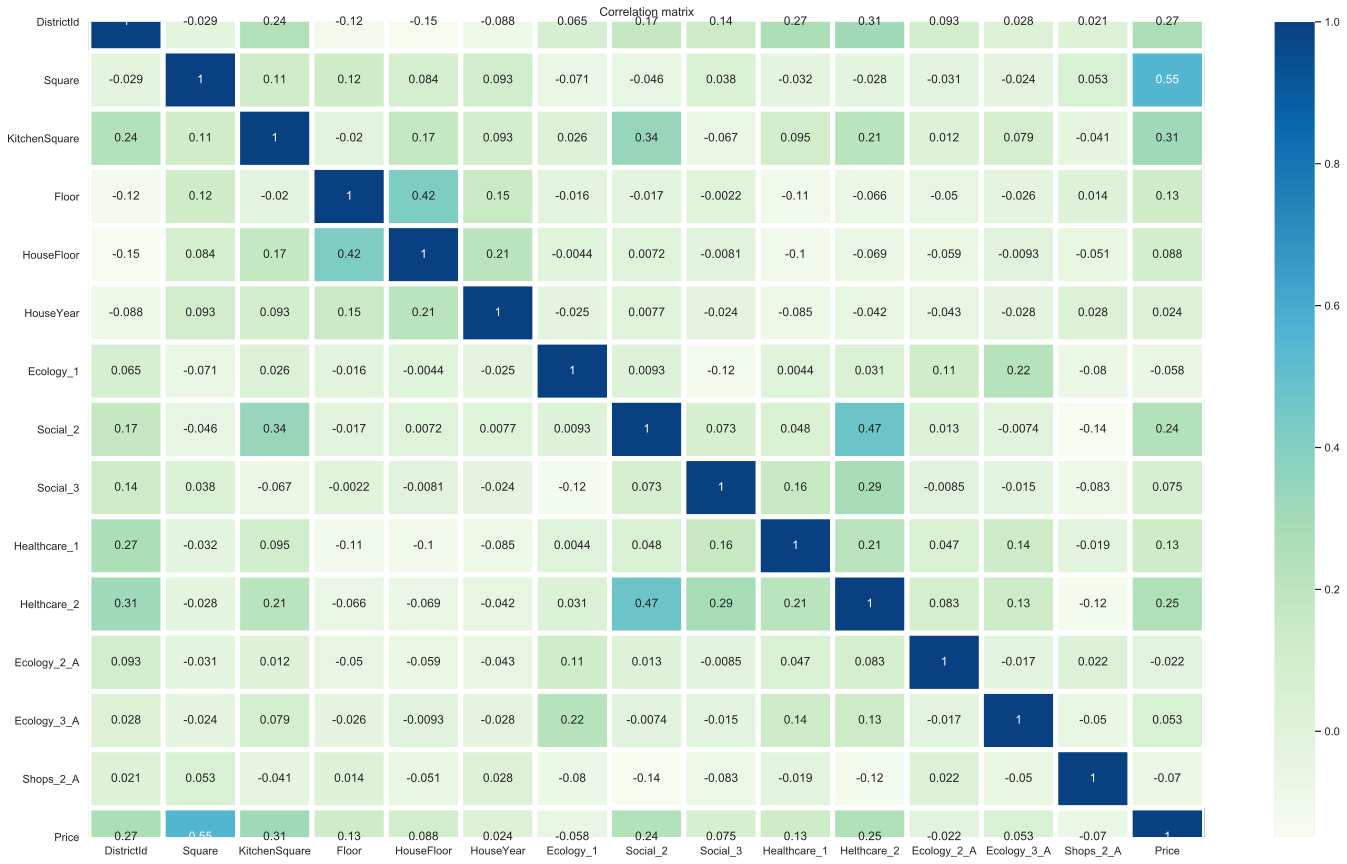

In [161]:
plt.figure(figsize=(25,15))
sns.set(font_scale=1.0)
sns.heatmap(df.corr(),annot=True,linewidths=5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

**Предсказываем цены для тестовых данных и делаем выгрузку**

In [164]:
test_df["Price"]=final_model.predict(test_df)

In [165]:
test_df.loc[:, ['Id', 'Price']].to_csv('KMVolkov_predictions.csv', index=False)